# Topopgraphy and rivers map of region (Tibet)

### Database

- [Earth2014](http://ddfe.curtin.edu.au/models/Earth2014/) (Arc‐min shape, topography, bedrock and ice‐sheet models)

### Package
- [Cartopy](https://scitools.org.uk/cartopy/docs/latest/) (A mapping and imaging package originating from the Met. Office in the UK)

Here downloads [Earth2014.TBI2014.5min.geod.bin](http://ddfe.curtin.edu.au/models/Earth2014/data_5min/topo_grids/)

In [1]:
import numpy as np
import os
import pyshtools as pysh
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
#from matplotlib.colors import LightSource
#from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
dir_db   = '../data/earth2014/data_5min/topo_grids'
fname_db = 'Earth2014.TBI2014.5min.geod.bin' 
fname_save  = 'Earth2014.TBI2014.5min' 

fname_topo = os.path.join(dir_db,fname_db)

In [3]:
# This scirpt shows how to access the data grids of earth2014 model
# Source code: access_Earth2014_grids5min.m (Christian Hirt, Moritz Rexer)

# grid definitions
res_deg = 5/60 # 5min data
extent_global = [-180, 180, -90, 90]
minlon,maxlon,minlat,maxlat = extent_global
lats = np.arange((minlat+res_deg/2),(maxlat-res_deg/4),res_deg)
lons = np.arange((minlon+res_deg/2),(maxlon-res_deg/4),res_deg)
nlat = len(lats)
nlon = len(lons)
order_db = nlat
minlon1,maxlon1,minlat1,maxlat1 = (lons.min(),lons.max(),lats.min(),lats.max())
extent_earth2014 = [minlon1,maxlon1,minlat1,maxlat1]

# read data
data_topo = np.fromfile(fname_topo, dtype='>i2').reshape((nlat, nlon))
data_topo = data_topo.astype(np.int16) # data = data.astype('<i2')
data_topo = np.flipud(data_topo)

In [4]:
# get SHCs
topo = pysh.SHGrid.from_array(data_topo)
coeffs = pysh.expand.SHExpandDH(topo.data, sampling=2)

# Map

In [5]:
name_area ='Tibet'
extent_area = [65,110,15,45]
# TRR (88,108,20,36)

order_s = order_db 
order_tRange = [1080,20]
#order_tRange = [2160,1080,720,540,360,240,120,80,40,30,20,15,10]
#order_tRange = [15,10,5,3,2,1]

# cartopy parameters
rivers = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '50m',
                                      edgecolor='Blue', facecolor="none")
coastline = cfeature.NaturalEarthFeature('physical', 'coastline', '50m',
                           edgecolor=(0.0,0.0,0.0),
                           facecolor="none")
lakes = cfeature.NaturalEarthFeature('physical', 'lakes', '50m',
                                        edgecolor="blue", facecolor="blue")
prj_base  = ccrs.PlateCarree() 

# plot parameters
extent_img = extent_earth2014  
extent_fig = extent_area
xticks = np.arange(-180,210,5)
yticks = np.arange(-90,120,5)
dpi    = 100
save_mode = True
arrow_width = 0.001
arrow_scale = 50000

In [6]:
# cmap = cm.terrain 
# norm = matplotlib.colors.Normalize(vmin=-4e3, vmax=8e3)

In [7]:
# # https://github.com/shaharkadmiel/cmaptools
from cmaptools import readcpt, joincmap, DynamicColormap

cptfile1 = '../data/cpt/seafloor.cpt'
cmap1 = readcpt(cptfile1)
cptfile2 = '../data/cpt/dem2.cpt'
cmap2 = readcpt(cptfile2)

cmap = joincmap(cmap1, cmap2)
cmap.set_range(-4e3, 8e3)
norm = cmap.norm

# cptfile = 'mby.cpt'
# cmap = readcpt(cptfile)
# cmap.set_range(-4e3, 8e3)
# norm = cmap.norm

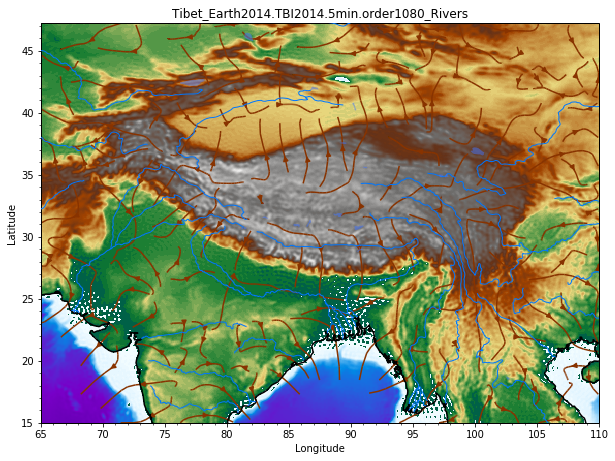

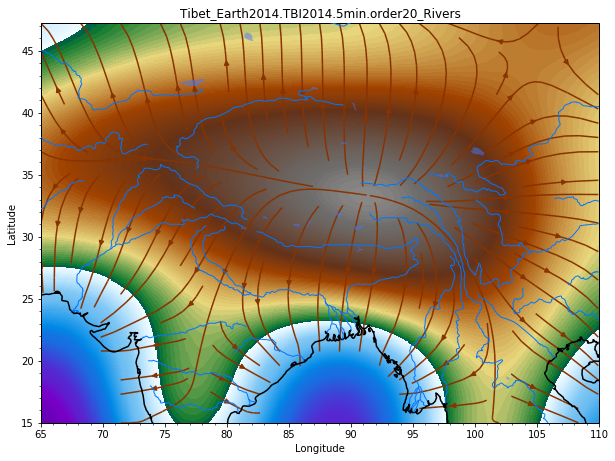

In [8]:
for i in range(0,len(order_tRange)):
    # filter by processing SHCs
    order_t = order_tRange[i]
    lmax = int(order_t+1)
    coeffs_f = coeffs.copy()
    coeffs_f[:, lmax:, :] = 0.
    topo_f = pysh.expand.MakeGridDH(coeffs_f, sampling=2)
    
    # plot parameters
    data_img = np.flipud(topo_f.copy())
    order_img = order_t
    fname_fig = name_area + '_'+ fname_save + '.order'+ str(order_img) + '_Rivers'
  
    # res_d = int(res/res_t)
    res_dy = 10 
    res_dx = 10 

    y = lats[::res_dy]
    x = lons[::res_dx] 
    X,Y = np.meshgrid(x,y)

    ZZ = data_img.copy()
    ZZ[ZZ<-500.0] = -500.0
    ZZ = ZZ[::res_dy,::res_dx]
    UY,UX= np.gradient(-ZZ)
    UX = UX.reshape((X.shape[0],X.shape[1]))
    UY = UY.reshape((X.shape[0],X.shape[1]))

#     mask = ZZ > -500.0
#     X_A=X[mask]
#     Y_A=Y[mask]
#     UX_A=UX[mask]
#     UY_A=UY[mask]

    fig = plt.figure(figsize=(10, 10), facecolor="none")
    ax = plt.axes(projection=prj_base)
    #ax.axis(extent_fig)
    ax.set(xlabel='Longitude', ylabel='Latitude', yticks=yticks, xticks=xticks)
    ax.minorticks_on()
    ax.set_title(fname_fig)
    ax.set_extent(extent_fig)
    
#     data_img2 = data_img.copy()
#     data_img2[abs(data_img-0)< 10.] = 10.
   
    im = ax.imshow(data_img, extent=extent_img,cmap=cmap,norm=norm) #,transform=prj_base)
    ax.streamplot(X, Y, UX, UY, density=1.0, color='#883300',zorder = 2)
    #ax.quiver(X_A,Y_A,UX_A,UY_A,width=arrow_width,scale=arrow_scale,zorder = 3)
    #ax.contour(X,Y,ZZ, zorder = 4)
    
#     divider = make_axes_locatable(ax)
#     cax = divider.append_axes("right", size="5%", pad=0.05)
#     cbar=plt.colorbar(im, cax=cax)
#     cbar.set_label('Elevation [m]')
    
    ax.add_feature(coastline, linewidth=1.5, edgecolor="Black", zorder=5)
    ax.add_feature(rivers,    linewidth=1.0, edgecolor="#0077FF", zorder=6)
    ax.add_feature(lakes,     linewidth=0,   edgecolor="Blue", facecolor="#4477FF", zorder=7, alpha=0.5)

    if save_mode == True:
        plt.savefig((fname_fig+'.png'),dpi=dpi)
    plt.show()